<a href="https://colab.research.google.com/github/yukuo333/ME599-Perception-Task/blob/main/RCNN/Bounding_box_car_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* *Self-driving Car Final Project --Image Classification*

# Set Up


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image as Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import cv2

# demo needed
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# training needed
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Download the dataset trainval & test

**Get access to google drive**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


check position of folder

**Read and print centroids.scv / labels.csv**


In [ ]:
file_centroids = pd.read_csv('/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/centroids.csv', header = 0)
file_labels = pd.read_csv('/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/labels.csv', header = 0)

**Read image dataset**

In [ ]:
files = glob('/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/*/*_image.jpg')
print(len(files))

7573


In [ ]:
classes = (
    'Unknown', 'Compacts', 'Sedans', 'SUVs', 'Coupes',
    'Muscle', 'SportsClassics', 'Sports', 'Super', 'Motorcycles',
    'OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles',
    'Boats', 'Helicopters', 'Planes', 'Service', 'Emergency',
    'Military', 'Commercial', 'Trains'
)

def rot(n):
    n = np.asarray(n).flatten()
    assert(n.size == 3)

    theta = np.linalg.norm(n)
    if theta:
        n /= theta
        K = np.array([[0, -n[2], n[1]], [n[2], 0, -n[0]], [-n[1], n[0], 0]])

        return np.identity(3) + np.sin(theta) * K + (1 - np.cos(theta)) * K @ K
    else:
        return np.identity(3)
def get_bbox(p0, p1):
    """
    Input:
    *   p0, p1
        (3)
        Corners of a bounding box represented in the body frame.

    Output:
    *   v
        (3, 8)
        Vertices of the bounding box represented in the body frame.
    *   e
        (2, 14)
        Edges of the bounding box. The first 2 edges indicate the `front` side
        of the box.
    """
    v = np.array([
        [p0[0], p0[0], p0[0], p0[0], p1[0], p1[0], p1[0], p1[0]],
        [p0[1], p0[1], p1[1], p1[1], p0[1], p0[1], p1[1], p1[1]],
        [p0[2], p1[2], p0[2], p1[2], p0[2], p1[2], p0[2], p1[2]]
    ])
    e = np.array([
        [2, 3, 0, 0, 3, 3, 0, 1, 2, 3, 4, 4, 7, 7],
        [7, 6, 1, 2, 1, 2, 4, 5, 6, 7, 5, 6, 5, 6]
    ], dtype=np.uint8)

    return v, e

**Split files into trainning set and validation set**

# Loop to get the reshaped images

In [ ]:
baseheight, basewidth = 224, 224
save_folder = '/content/gdrive/MyDrive/cutimg_224/'
train_images=[]
train_labels=[]

#for idx in range(num_split):
for idx in range(1):
  snapshot = files[idx]
  img = plt.imread(snapshot)

  xyz = np.fromfile(snapshot.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
  xyz = xyz.reshape([3, -1])

  proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
  proj.resize([3, 4])

  try:
    bbox = np.fromfile(snapshot.replace('_image.jpg', '_bbox.bin'), dtype=np.float32)
  except FileNotFoundError:
    continue
      #print('[*] bbox not found.')
      #bbox = np.array([], dtype=np.float32)

  bbox = bbox.reshape([-1, 11])
  uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
  uv = uv / uv[2, :]
  dist = np.linalg.norm(xyz, axis=0)
  
  step = 5
  colors = ['C{:d}'.format(i) for i in range(10)]
  for k, b in enumerate(bbox):
      R = rot(b[0:3])
      t = b[3:6]
      sz = b[6:9]
      vert_3D, edges = get_bbox(-sz / 2, sz / 2)
      vert_3D = R @ vert_3D + t[:, np.newaxis]
      vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
      vert_2D = vert_2D / vert_2D[2, :]

      clr = colors[np.mod(k, len(colors))]

  # boundary contain all the vehilce
  maxx,minx,maxy,miny = round( max(vert_2D[0,:])), round(min(vert_2D[0,:])), round (max(vert_2D[1,:])) , round(min(vert_2D[1,:]))
  maxx, minx, maxy, miny = min(max(maxx,0),1914), min(max(minx,0),1914), min(max(maxy,0),1052), min(max(miny,0),1052)
  if maxx<=minx or maxy<=miny:
    continue
  cut_image = img[miny:maxy, minx:maxx,:]

  img_reshaped = cv2.resize(cut_image, dsize=(baseheight, basewidth), interpolation=cv2.INTER_CUBIC)
  
  im = Image.fromarray(img_reshaped)
  s_arr = snapshot.split('/')

  label_here = list(file_labels[ file_labels['guid/image'] == '/'.join(s_arr[-2:])[:-10] ]['label'])[0]

  # save_dir = save_folder + str(label_here) +'/'+ '_'.join(s_arr[-2:])[:-10] + '_cutimg.jpg'
  # im.save(save_dir)

  #train_images.append(img_reshaped)
  #train_labels.append(label_here)



NameError: ignored

# Selective search

initialise a new selective search

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

initialising the function to calculate IOU (Intersection Over Union) of the ground truth box from the box computed by selective search.

In [ ]:
# def get_iou(bb1, bb2):
#     assert bb1['x1'] < bb1['x2']
#     assert bb1['y1'] < bb1['y2']
#     assert bb2['x1'] < bb2['x2']
#     assert bb2['y1'] < bb2['y2']
#     x_left = max(bb1['x1'], bb2['x1'])
#     y_top = max(bb1['y1'], bb2['y1'])
#     x_right = min(bb1['x2'], bb2['x2'])
#     y_bottom = min(bb1['y2'], bb2['y2'])
#     if x_right < x_left or y_bottom < y_top:
#         return 0.0
#     intersection_area = (x_right - x_left) * (y_bottom - y_top)
#     bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
#     bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
#     iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
#     assert iou >= 0.0
#     assert iou <= 1.0
#     return iou

pre-processing and creating the data-set to pass to the model. 

1. Loop over the image folder and set each image one by one as the base for selective search using code ss.setBaseImage(image)

2. Initialising fast selective search and getting proposed regions using using code ss.switchToSelectiveSearchFast() and ssresults = ss.process()

3. Iterating over all the first 2000 results passed by selective search and calculating IOU of the proposed region and annotated region using the get_iou() function created above.

4. Now as one image can many negative sample (i.e. background) and just some positive sample (i.e. airplane) so we need to make sure that we have good proportion of both positive and negative sample to train our model. Therefore we have set that we will collect maximum of 30 negative sample (i.e. background) and positive sample (i.e. airplane) from one image.

After running the above code snippet our training data will be ready. List train_images=[] will contain all the images and train_labels=[] will contain all the labels marking airplane images as 1 and non airplane images (i.e. background images) as 0.

In [ ]:
# train_images=[]
# train_labels=[]
# for e,i in enumerate(os.listdir(annot)):
#     try:
#         if i.startswith("airplane"):
#             filename = i.split(".")[0]+".jpg"
#             print(e,filename)
#             image = cv2.imread(os.path.join(path,filename))
#             df = pd.read_csv(os.path.join(annot,i))
#             gtvalues=[]
#             for row in df.iterrows():
#                 x1 = int(row[1][0].split(" ")[0])
#                 y1 = int(row[1][0].split(" ")[1])
#                 x2 = int(row[1][0].split(" ")[2])
#                 y2 = int(row[1][0].split(" ")[3])
#                 gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
#             ss.setBaseImage(image)
#             ss.switchToSelectiveSearchFast()
#             ssresults = ss.process()
#             imout = image.copy()
#             counter = 0
#             falsecounter = 0
#             flag = 0
#             fflag = 0
#             bflag = 0
#             for e,result in enumerate(ssresults):
#                 if e < 2000 and flag == 0:
#                     for gtval in gtvalues:
#                         x,y,w,h = result
#                         iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
#                         if counter < 30:
#                             if iou > 0.70:
#                                 timage = imout[y:y+h,x:x+w]
#                                 resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
#                                 train_images.append(resized)
#                                 train_labels.append(1)
#                                 counter += 1
#                         else :
#                             fflag =1
#                         if falsecounter <30:
#                             if iou < 0.3:
#                                 timage = imout[y:y+h,x:x+w]
#                                 resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
#                                 train_images.append(resized)
#                                 train_labels.append(0)
#                                 falsecounter += 1
#                         else :
#                             bflag = 1
#                     if fflag == 1 and bflag == 1:
#                         print("inside")
#                         flag = 1
#     except Exception as e:
#         print(e)
#         print("error in "+filename)
#         continue

# CNN train

import pretrained model

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
lzero_files = glob('/content/gdrive/MyDrive/cutimg_224/0/*_cutimg.jpg')
lone_files = glob('/content/gdrive/MyDrive/cutimg_224/1/*_cutimg.jpg')
ltwo_files = glob('/content/gdrive/MyDrive/cutimg_224/2/*_cutimg.jpg')
train_images=[]
train_labels=[0]*len(lzero_files) + [1]*len(lone_files) + [2]*len(ltwo_files)

cut_files = lzero_files + lone_files + ltwo_files

for idx in range(len(cut_files)):
  snapshot = cut_files[idx]
  img_resized = plt.imread(snapshot)
  train_images.append(img_resized)


In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
X= vggmodel.layers[-2].output
predictions = Dense(3, activation="softmax")(X)
model_final = Model(vggmodel.input,predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

training of the model using fit_generator.

In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 100, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.5624 - accuracy: 0.5188 
Epoch 00001: val_loss improved from inf to 0.87426, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 251s 25s/step - loss: 1.5624 - accuracy: 0.5188 - val_loss: 0.8743 - val_accuracy: 0.5469
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.7969 - accuracy: 0.5938 
Epoch 00002: val_loss improved from 0.87426 to 0.59242, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 246s 25s/step - loss: 0.7969 - accuracy: 0.5938 - val_loss: 0.5924 - val_accuracy: 0.7344
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 0.7531 
Epoch 00003: val_loss did not improve from 0.59242
10/10 [==============================] - 237s 24s/step - loss: 0.5533 - accuracy: 0.7531 - val_loss: 0.7218 - val_accuracy: 0.6719
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 

# Save and Load the Trained model

save the trained model

In [ ]:
# serialize model to JSON
model_json = model_final.to_json()
with open("/content/gdrive/MyDrive/rcnn_model.json", "a") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model_final.save_weights("/content/gdrive/MyDrive/rcnn_model.h5")
print("Saved final model to disk")

Saved final model to disk


In [ ]:
# with open('/content/gdrive/MyDrive/rcnn_model_try.json','r') as f:
#     json = f.read()
# premodel = read("ieeercnn_vgg16_1.h5")

NameError: ignored

load trained model

In [ ]:
# load json and create model
# json_file = open('/content/gdrive/MyDrive/rcnn_model_try.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

from keras.models import model_from_json

with open('/content/gdrive/MyDrive/rcnn_model.json','r') as f:
    json = f.read()
loaded_model = model_from_json(json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/MyDrive/rcnn_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Loaded model from disk
accuracy: 91.29%


In [ ]:
# # Save the entire model as a SavedModel.
# !mkdir -p saved_model
# model.save('saved_model/my_model') 

In [ ]:
# # my_model directory
# !ls saved_model

# # Contains an assets folder, saved_model.pb, and variables folder.
# !ls saved_model/my_model

# Prediction on the model

prediction

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
z=0

load test files

In [ ]:
test_files = glob('/content/gdrive/MyDrive/rob535-fall2021-final-project-data/test/*/*_image.jpg')
print(len(test_files))

2631


try the prediction on a selected model to evaluate its performance

/content/gdrive/MyDrive/rob535-fall2021-final-project-data/test/f777190f-47f5-48af-aade-c73fc0fa8171/0037_image.jpg


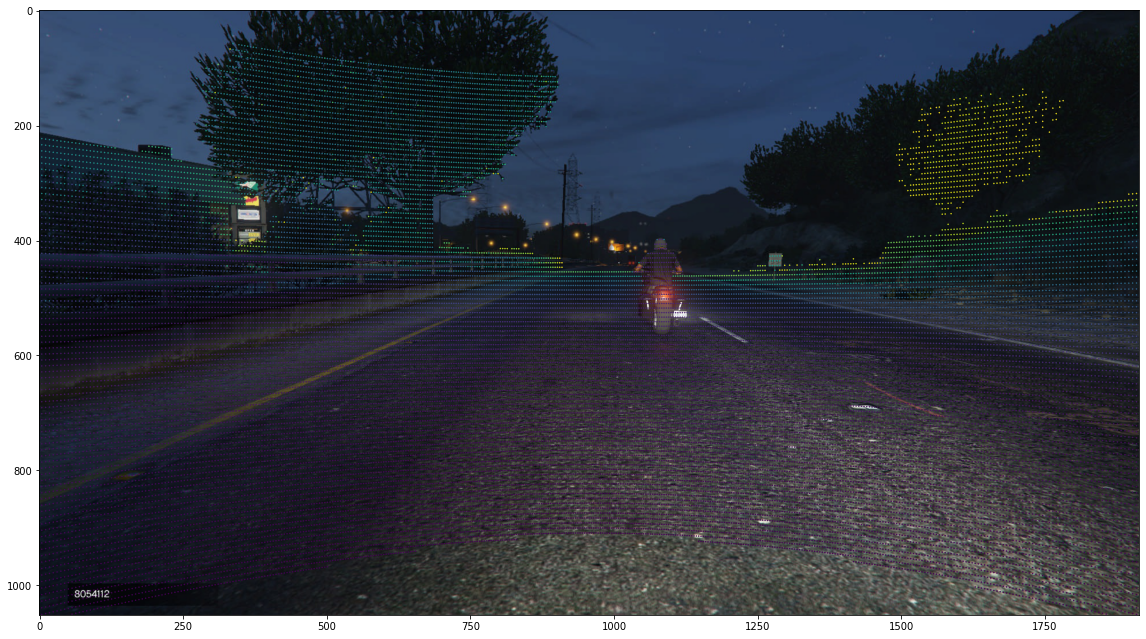

In [ ]:
idx =2500
snapshot = test_files[idx]
print(snapshot)

img = plt.imread(snapshot)

xyz = np.fromfile(snapshot.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
xyz = xyz.reshape([3, -1])

proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
proj.resize([3, 4])

uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
uv = uv / uv[2, :]
dist = np.linalg.norm(xyz, axis=0)
fig1 = plt.figure(1, figsize=(16, 9))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.imshow(img)
ax1.scatter(uv[0, :], uv[1, :], c=dist, marker='.', s=1)
ax1.axis('scaled')
fig1.tight_layout()

plt.show()

In [ ]:
img = cv2.imread(snapshot)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()

0.8718529 [  0 213 452 213]
0.95939016 [874 245 223 168]
0.8794318 [  0 214 452 212]
0


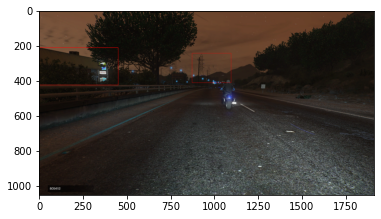

In [ ]:
one_count, two_count = 0, 0
for e,result in enumerate(ssresults):
        x,y,w,h = result
        if w*h>150*150:
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= loaded_model.predict(img)
            
            if out[0][0] > 1.5:
                print(out[0][0],result)
                two_count +=1
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            elif out[0][0] > 0.85:
                print(out[0][0],result)
                one_count+=1
                cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_AA)
            if two_count>20 or one_count>20:
                break

if one_count==0 and two_count == 0:
    out_label = 0
elif one_count>two_count:
    outlabel = 1
else:
    out_label = 2

print(out_label)
plt.figure()
plt.imshow(imout)